importing packages

In [1]:
import matplotlib.pyplot as plt #to print out graphs
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import math
import copy
%matplotlib inline

In [2]:
# TODO
import keras.backend as K
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential

Using TensorFlow backend.


ModuleNotFoundError: No module named 'keras_vggface'

In [ ]:
K.clear_session()

In [3]:
K.set_image_data_format( 'channels_last' )# we created the dataset of size 224*224 
nrow = 224
ncol = 224

In [4]:
vggface = VGGFace(model='vgg16') 
vggface.summary()

NameError: name 'VGGFace' is not defined

In [6]:
#custom parameters
# 10 Names, 10 classes
nb_class = 5
hidden_dim = 512

vgg_notop = VGGFace(include_top=False, input_shape=(224, 224, 3))
for layer in vgg_notop.layers:
    layer.trainable = False

last_layer = vgg_notop.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)

custom_vgg_model = Model(vgg_notop.input, out)

# Create two more models for future use
custom_vgg_model2 = Model(vgg_notop.input, out)
custom_vgg_model3 = Model(vgg_notop.input, out)

custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [7]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 8

train_data_dir = './facesqq/train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 5000 images belonging to 5 classes.


In [8]:
test_data_dir = './facesqq/validation'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 1250 images belonging to 5 classes.


In [9]:
import os
datasetDescriptor = './facesqq/train'
textFileNames = os.listdir(datasetDescriptor)

print(textFileNames)

['amar', 'anirudh', 'manish_kharbuja', 'manish_nhuchhe', 'sunder']


In [10]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

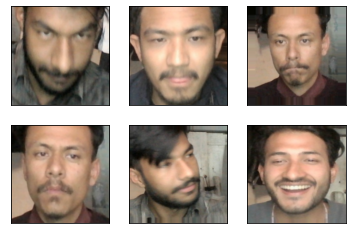

In [11]:
batch_shape = (batch_size,custom_vgg_model.input_shape[1] , 
               custom_vgg_model.input_shape[2], 
               custom_vgg_model.input_shape[3])
X = np.zeros(batch_shape)
y = np.zeros(batch_size)

X,y = train_generator.next()
nplot = 6        
for i in range(nplot):    
    plt.subplot(2,nplot/2,i+1)
    disp_image(X[i,:,:,:])
    

In [12]:
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

In [13]:
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 10

history=custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/10
625/625 [==============================] - 89s 142ms/step - loss: 1.3232 - accuracy: 0.8046 - val_loss: 0.8861 - val_accuracy: 0.9824
Epoch 2/10
625/625 [==============================] - 87s 140ms/step - loss: 0.7044 - accuracy: 0.9936 - val_loss: 0.3711 - val_accuracy: 0.9992
Epoch 3/10
625/625 [==============================] - 87s 139ms/step - loss: 0.3368 - accuracy: 0.9978 - val_loss: 0.3704 - val_accuracy: 1.0000
Epoch 4/10
625/625 [==============================] - 87s 140ms/step - loss: 0.1889 - accuracy: 0.9980 - val_loss: 0.1249 - val_accuracy: 1.0000
Epoch 5/10
625/625 [==============================] - 89s 142ms/step - loss: 0.1263 - accuracy: 0.9988 - val_loss: 0.0770 - val_accuracy: 1.0000
Epoch 6/10
625/625 [==============================] - 93s 149ms/step - loss: 0.0919 - accuracy: 0.9982 - val_loss: 0.0992 - val_accuracy: 0.9992
Epoch 7/10
625/625 [==============================] - 87s 139ms/step - loss: 0.0717 - accuracy: 0.9994 - val_loss: 0.0524 - val_ac

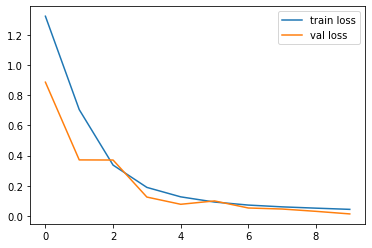

<Figure size 432x288 with 0 Axes>

In [14]:
#loss graph
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.savefig('Loss VS Val_ Loss')

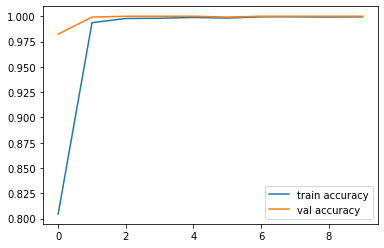

<Figure size 432x288 with 0 Axes>

In [15]:
#accuracy graph
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy VS Val_accuracy')

In [16]:
import tensorflow as tf
from keras.models import load_model
custom_vgg_model.save('face_new_model.h5')

In [19]:
test_data_dir = './facesqq/validation'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   # Add rotation 
                                   rotation_range=90,
                                   # Add flip
                                   vertical_flip=True,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 1250 images belonging to 5 classes.


Let's print some photos to see the result.

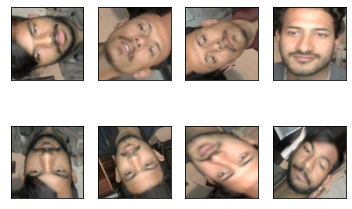

In [20]:
X,y = test_generator.next()
nplot = 8
for i in range(nplot):    
    plt.subplot(2,nplot/2,i+1)
    disp_image(X[i,:,:,:])
    #title = (textFileNames[y[i]])
   # plt.title(title)

## Train the customized model again

In [21]:
custom_vgg_model2.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 10

history1=custom_vgg_model2.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/10
625/625 [==============================] - 88s 141ms/step - loss: 0.0382 - accuracy: 0.9992 - val_loss: 1.2091 - val_accuracy: 0.4263
Epoch 2/10
625/625 [==============================] - 87s 139ms/step - loss: 0.0355 - accuracy: 0.9994 - val_loss: 0.9841 - val_accuracy: 0.4557
Epoch 3/10
625/625 [==============================] - 86s 138ms/step - loss: 0.0318 - accuracy: 0.9994 - val_loss: 1.5894 - val_accuracy: 0.4291
Epoch 4/10
625/625 [==============================] - 87s 138ms/step - loss: 0.0286 - accuracy: 0.9994 - val_loss: 1.2183 - val_accuracy: 0.4259
Epoch 5/10
625/625 [==============================] - 87s 140ms/step - loss: 0.0272 - accuracy: 0.9994 - val_loss: 1.3592 - val_accuracy: 0.4259
Epoch 6/10
625/625 [==============================] - 87s 139ms/step - loss: 0.0241 - accuracy: 0.9998 - val_loss: 1.3191 - val_accuracy: 0.4372
Epoch 7/10
625/625 [==============================] - 87s 139ms/step - loss: 0.0226 - accuracy: 0.9994 - val_loss: 1.3654 - val_ac

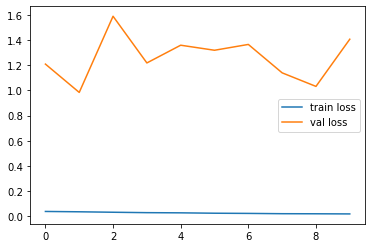

<Figure size 432x288 with 0 Axes>

In [22]:
#loss graph
plt.plot(history1.history['loss'], label = 'train loss')
plt.plot(history1.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.savefig('Loss VS Val_ Loss')

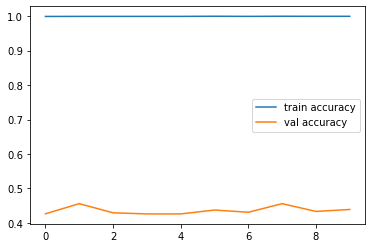

<Figure size 432x288 with 0 Axes>

In [23]:
#accuracy graph
plt.plot(history1.history['accuracy'], label = 'train accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy VS Val_accuracy')

In [24]:
import tensorflow as tf
from keras.models import load_model
custom_vgg_model2.save('face_new_model2.h5')

In [25]:
train_data_dir = './facesqq/train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   # Add rotation
                                   rotation_range=90,
                                   # Add flip
                                   vertical_flip=True,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 5000 images belonging to 5 classes.


In [26]:
custom_vgg_model3.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

history2=custom_vgg_model3.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/10
625/625 [==============================] - 86s 138ms/step - loss: 1.1448 - accuracy: 0.5662 - val_loss: 1.0556 - val_accuracy: 0.7067
Epoch 2/10
625/625 [==============================] - 86s 138ms/step - loss: 1.0276 - accuracy: 0.7168 - val_loss: 0.9106 - val_accuracy: 0.8100
Epoch 3/10
625/625 [==============================] - 86s 138ms/step - loss: 0.9149 - accuracy: 0.8016 - val_loss: 1.0276 - val_accuracy: 0.8696
Epoch 4/10
625/625 [==============================] - 88s 141ms/step - loss: 0.8497 - accuracy: 0.8362 - val_loss: 0.6127 - val_accuracy: 0.9018
Epoch 5/10
625/625 [==============================] - 86s 138ms/step - loss: 0.7565 - accuracy: 0.8666 - val_loss: 0.5415 - val_accuracy: 0.9316
Epoch 6/10
625/625 [==============================] - 86s 138ms/step - loss: 0.6836 - accuracy: 0.8892 - val_loss: 0.5323 - val_accuracy: 0.9171
Epoch 7/10
625/625 [==============================] - 86s 138ms/step - loss: 0.6078 - accuracy: 0.9020 - val_loss: 0.3920 - val_ac

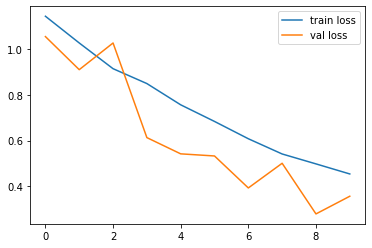

<Figure size 432x288 with 0 Axes>

In [27]:
#loss graph
plt.plot(history2.history['loss'], label = 'train loss')
plt.plot(history2.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.savefig('Loss VS Val_ Loss')

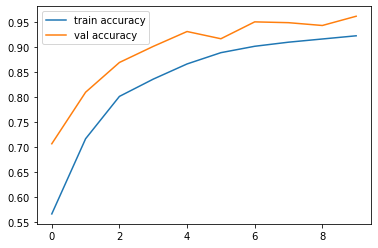

<Figure size 432x288 with 0 Axes>

In [28]:
#accuracy graph
plt.plot(history2.history['accuracy'], label = 'train accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy VS Val_accuracy')

In [ ]:
import tensorflow as tf
from keras.models import load_model
custom_vgg_model3.save('face_new_model3.h5')